<a target="_blank" href="https://colab.research.google.com/github/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_llm_full_fine_tune_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

> **Note:** If you're running in Google Colab, make sure to enable GPU usage by going to Runtime -> Change runtime type -> select GPU.

[Source Code](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_llm_full_fine_tune_tutorial.ipynb)

## Overview

Why fine-tune a Small Language Model (SLM)?

Because we want small model for a specific task (e.g. don't to pay API credits or leak our data online).

If we have our own model... we can run it anywhere and everywhere we like.

## How to fine-tune an LLM model

There are several ways to fine-tune an LLM including reinforcement learning (RL) and Supervised Fine-tuning (SFT).

We are going to do SFT because it's the most straightforward. 

Basically SFT = give samples of inputs and outputs and the model learns to map a given input to a given output.

For example if our goal was to extract names: 

- Input: Hello my name is Daniel
- Output: Daniel

Note:

* Our inputs can be *any* kind of input string.
* Our outputs will be fine-tuned to conform to a structured data pattern.

::: {.callout-tip}
## LLM Fine-tuning Mindset

In LLM world, data inputs are tokens and data outputs are tokens.

A token is a numerical representation of some kind of data.

Computers like numbers (not images, text, videos, etc).

Everything must be turned into numbers.

And data = a very broad term.

It could be text, images, video (series of images), audio, DNA sequences, Excel spreadsheets, you name it.

The goal of the LLM is to be given an input sequence of tokens and then predict the following tokens.

So with this mindset, you can think of any problem as **tokens in, tokens out**.

Ask yourself: *What tokens do I want to put in and what tokens do I want my model to return?*

In our case, we want to put in almost any string input. And we want to get back structured information specifically related to food and drinks.

This a very specific use case, however, the beauty of LLMs being so general is that you can apply this **tokens in, tokens out** mindset to almost anything.

If you've got an existing dataset (no problem if you don't, you can create one, let me know if you'd like a guide on this), chances are, you can fine-tune an LLM to do pretty well on it.
:::

## What we're cooking

We're going to build a SLM (Small Language Model) to extract food and drink items from text.

Why?

If we needed to go over a large dataset of image captions and filter them for food items (we could then use these filtered captions for a food app).

TK image - example of what we're doing.

## Ingredients

1. Model ([Gemma-3-270M](https://huggingface.co/google/gemma-3-270m-it))
2. [Dataset](https://huggingface.co/datasets/mrdbourke/FoodExtract-1k) (a pre-baked dataset to extract foods and drinks from text)
3. Training code (Hugging Face Transformers + TRL)
4. Eval code
5. Demo

## Method

1. Download model - [Hugging Face `transformers`](https://huggingface.co/docs/transformers/index)
2. Download dataset - [Hugging Face `datasets`](https://huggingface.co/docs/datasets/en/index)
3. Inspect dataset - Hugging Face `datasets` 
4. Train model on dataset - [Hugging Face `trl`](https://huggingface.co/docs/trl/en/index) (TRL = Transformers Reinforcement Learning)
5. Eval model - basically just look at a bunch of samples
6. Create an interactive demo - Hugging Face `gradio` 
7. Bonus: Make the demo public so other people can use it - Hugging Face Spaces

## Fine-tuning LLM vs RAG

* Fine-tuning = To do a very specific task, e.g. structured data extraction.
    * An example would be you're an insurance company who gets 10,000 emails a day and you want to extract structured data directly from these emails to JSON.
* RAG = You want to inject custom knowledge into an LLM.
    * An example would be you're an insurance company wanting to send *automatic* responses to people but you want the responses to include information from your own docs.

## Why fine-tune your own model?

1. Own the model, can run on own hardware
2. Our task is simple enough to just use a small language model
3. No API calls needed 
4. Can run in batch mode to get much faster inference than API calls
5. Model by default wasn't very good at our task but now since fine-tuning, is *very good* 

## Definitions

Some quick definitions of what we're doing.

* **Full fine-tuning** - All weights on the model are updated. Often takes longer and requires larger hardware capacity, however, if your model is small enough (e.g. 270M parameter or less), you can often do full fine-tuning.
* **LORA fine-tuning** (also known as partial fine-tuning) - [Low Rank Adaptation](https://arxiv.org/abs/2106.09685) or training a small adapter to attach to your original model. Requires significantly less resources but [can perform on par with full fine-tuning](https://thinkingmachines.ai/blog/lora/). 
* **SLM (Small Language Model)** - A subjective definition but to me a Small Language Model is a model with under 1B parameters, with added bonus for being under 500M parameters. Less parameters generally means less performance. However, when you have a specific task, SLMs often shine because they can be tailored for that specific task. If your task is "I want to create a chatbot capable of *anything*", you'll generally want the biggest model you can reasonably serve. If your task is "I want to extract some structured data from raw text inputs", you'll probably be surprised how well a SLM can perform.

## Import dependencies

> **Note:** If you're in Google Colab, you may have to install `trl`, `accelerate` and `gradio`.

For Google Colab:

```python
!pip install trl accelerate gradio
```


In [1]:
import transformers 
import trl # trl = Transformers Reinforcement Learning -> https://github.com/huggingface/trl 
import datasets 
import accelerate

import gradio as gr

In [2]:
# Check the amount of GPU memory available (we need at least ~16GB)
import torch

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(device)
    
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    reserved_memory = torch.cuda.memory_reserved(device)
    free_memory = total_memory - reserved_memory
    
    print(f"GPU: {gpu_name}")
    print(f"Total Memory:     {total_memory / 1e6:.2f} MB | {total_memory / 1e9:.2f} GB")
    print(f"Allocated Memory: {allocated_memory / 1e6:.2f} MB | {allocated_memory / 1e9:.2f} GB")
    print(f"Reserved Memory:  {reserved_memory / 1e6:.2f} MB | {reserved_memory / 1e9:.2f} GB")
    print(f"Free Memory:      {free_memory / 1e6:.2f} MB | {free_memory / 1e9:.2f} GB")
else:
    print("No CUDA GPU available")

GPU: NVIDIA GB10
Total Memory:     128524.03 MB | 128.52 GB
Allocated Memory: 0.00 MB | 0.00 GB
Reserved Memory:  0.00 MB | 0.00 GB
Free Memory:      128524.03 MB | 128.52 GB


/home/mrdbourke/miniforge3/envs/ai/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


## Setup Base Model 

The base model we'll be using is [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m-it/tree/main) from Google.

It's the same architecture style as larger LLMs such as Gemini but at a *much* smaller scale.

This is why we refer to it as a "Small Language Model" or SLM.

We can load our model using `transformers`.

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "google/gemma-3-270m-it" # note: "it" stands for "instruction tuned" which means the model has been tuned for following instructions

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype="auto",
    device_map="auto", # put the model on the GPU
    attn_implementation="eager" # could use flash_attention_2 but ran into issues... so stick with Eager for now
)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

[INFO] Model on device: cuda:0
[INFO] Model using dtype: torch.bfloat16


Our model requires numbers (tokens) as input.

We can turn strings into tokens via a tokenizer!

In [5]:
tokenizer("Hello my name is Daniel")

{'input_ids': [2, 9259, 1041, 1463, 563, 13108], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [6]:
import torch 

outputs = model(torch.tensor(tokenizer("Hello my name is Daniel")["input_ids"]).unsqueeze(0).to("cuda"))
outputs.keys()

odict_keys(['logits', 'past_key_values'])

## Get dataset

Our dataset is located here: [https://huggingface.co/datasets/mrdbourke/FoodExtract-1k](https://huggingface.co/datasets/mrdbourke/FoodExtract-1k). 

It was created from image captions + random strings and then using `gpt-oss-120b` (a powerful open-source LLM) to do synthetic labelling.

For more on the dataset you can read the [README.md](https://huggingface.co/datasets/mrdbourke/FoodExtract-1k) file explaining it.

The main thing we are concerned about is that we want the input to our model to be the `"sequence"` column and the output to be the `"gpt-oss-120b-label-condensed"` column.

We'll explore these below.

In [7]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of samples in the dataset: {len(dataset['train'])}")

[INFO] Number of samples in the dataset: 1420


In [8]:
import json
import random

def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in the dataset."""
    random_idx = random.randint(0, len(dataset)-1)
    return random_idx


random_idx = get_random_idx(dataset["train"])
random_sample = dataset["train"][random_idx]

example_input = random_sample["sequence"]
example_output = random_sample["gpt-oss-120b-label"]
example_output_condensed = random_sample["gpt-oss-120b-label-condensed"]

print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example structured output (what we want our model to learn to predict):")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):")
print(example_output_condensed)

[INFO] Input:
The image depicts a classic British red double-decker bus adorned with a "Wedding Special" sign at the back, alongside a contact number, 01474-353-896, and a license plate reading JJ04020. The bus, highlighted by a gold trim separating its two levels, is parked within the vicinity of a Shell gas station, with the station's pumps and yellow Shell emblem visible on the left. The bus rests closely to the curb, making it appear as though maneuvering in this space might be challenging. Another vehicle is seen fueling up nearby. A prominently placed sign in the bottom right corner reads, "Shell Drivers Club Points: I exchange mine for coffee. Don't lose your points. Register today." The sky above is overcast, contributing to the overall cloudy ambiance of the scene. No people are visible in the photograph.

[INFO] Example structured output (what we want our model to learn to predict):
{'is_food_or_drink': True, 'tags': ['di', 'fa'], 'food_items': [], 'drink_items': ['coffee']}


Because we'd like to use our model to potentially filter a large corpus of data, we get it assign various tags to the text as well.

These are as follows.

In [9]:
# Our fine-tuned model will assign tags to text so we can easily filter them by type in the future
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}

### Format the dataset into LLM-style inputs/outputs

Right now we have examples of string-based inputs and structured outputs.

However, our LLMs generally want things in the format of: 

```
{"user": "Hello my name is Daniel",
"system": "Hi Daniel, I'm an LLM"}
```

In other words, they want structure around the intputs and outputs rather than just raw information.

> **Resource:** See the dataset formats and types in the TRL docs: https://huggingface.co/docs/trl/en/dataset_formats 

In [10]:
random_sample

{'sequence': 'The image depicts a classic British red double-decker bus adorned with a "Wedding Special" sign at the back, alongside a contact number, 01474-353-896, and a license plate reading JJ04020. The bus, highlighted by a gold trim separating its two levels, is parked within the vicinity of a Shell gas station, with the station\'s pumps and yellow Shell emblem visible on the left. The bus rests closely to the curb, making it appear as though maneuvering in this space might be challenging. Another vehicle is seen fueling up nearby. A prominently placed sign in the bottom right corner reads, "Shell Drivers Club Points: I exchange mine for coffee. Don\'t lose your points. Register today." The sky above is overcast, contributing to the overall cloudy ambiance of the scene. No people are visible in the photograph.',
 'image_url': 'https://live.staticflickr.com/821/26423687377_ea486a390d_h.jpg',
 'class_label': 'not_food',
 'source': 'pixmo_cap_dataset',
 'char_len': 811.0,
 'word_cou

In [11]:
def sample_to_conversation(sample):
    """Helper function to convert an input sample to conversation style."""
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user',
   'content': 'The image depicts a classic British red double-decker bus adorned with a "Wedding Special" sign at the back, alongside a contact number, 01474-353-896, and a license plate reading JJ04020. The bus, highlighted by a gold trim separating its two levels, is parked within the vicinity of a Shell gas station, with the station\'s pumps and yellow Shell emblem visible on the left. The bus rests closely to the curb, making it appear as though maneuvering in this space might be challenging. Another vehicle is seen fueling up nearby. A prominently placed sign in the bottom right corner reads, "Shell Drivers Club Points: I exchange mine for coffee. Don\'t lose your points. Register today." The sky above is overcast, contributing to the overall cloudy ambiance of the scene. No people are visible in the photograph.'},
  {'role': 'system',
   'content': 'food_or_drink: 1\ntags: di, fa\nfoods: \ndrinks: coffee'}]}

In [12]:
# Map our sample_to_conversation function to dataset 
dataset = dataset.map(sample_to_conversation,
                      batched=False)

dataset["train"][0]

Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

Notice how we now have a `"messages"` key in our dataset samples.

In [13]:
# Create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2,
                                            shuffle=False,
                                            seed=42)

# Number #1 rule in machine learning
# Always train on the train set and test on the test set
# This gives us an indication of how our model will perform in the real world
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

### Try the model with a pipeline

In [14]:
easy_sample = {"role": "user", 
               "content": "Hi my name is Daniel"}

def create_easy_sample(input):
    template = {"role": "user", "content": input}
    return template


In [15]:
from transformers import pipeline 

# Load model and use it as a pipeline
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer)

input_text = "Hi my name is Daniel. Please reply to me with a machine learning poem."
easy_sample = create_easy_sample(input=input_text)
input_prompt = pipe.tokenizer.apply_chat_template([easy_sample], # pipeline tokenizer wants a list of inputs
                                                  tokenize=False,
                                                  add_generation_prompt=True)

print(f"[INFO] This is the input prompt: {input_prompt}")

default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {MODEL_NAME}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Device set to use cuda:0


[INFO] This is the input prompt: <bos><start_of_turn>user
Hi my name is Daniel. Please reply to me with a machine learning poem.<end_of_turn>
<start_of_turn>model

[INFO] Input:
Hi my name is Daniel. Please reply to me with a machine learning poem.

[INFO] Output from google/gemma-3-270m-it:

Hi Daniel,
Your poem is a beautiful and thoughtful reflection on the journey of learning. It captures a sense of wonder and the endless possibilities that come with it.



Example machine learning poem generated by Gemma 3 270M (not too bad):

```
Okay, Daniel, here's a machine learning poem. I've tried to capture a feeling of wonder and a bit of mystery.

The algorithm learns,
A silent, tireless quest.
Through data streams, it flows,
A symphony of thought.
Each point a new layer,
A learning bloom,
A future bright and clear.

It analyzes the data,
No single clue it knows.
It weaves a pattern true,
A story in the hue.
The world unfolds anew,
With subtle, complex view.

It's not just numbers,
But feeling, a soul.
A tapestry of grace,
A hopeful, vibrant space.
A learning, growing deep,
Secrets it will keep.
```

### Try the model on one of our sequences

In [16]:
# Get a random sample
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
I)$=~(n;("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png<end_of_turn>
<start_of_turn>model


[INFO] Output:
I$ = ~(n; ("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png`)



By default the model produces a fairly generic response.

This is expected and good.

It means the model has a good baseline understanding of language.

If it responded with pure garbage, we might have an uphill battle.

However, this response type is not what we want. We want our model to respond with **structured data** based on the input.

Good news is we can adjust the patterns in our model to do just that.

### Let's try to prompt the model

We want a model to extract food and drink items from text.

By default the model will just reply to any text input with a generic response.

However, we can try and get our ideal outputs via prompting.

In [17]:
prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]
    
    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_train_sample)[0]["content"])

[INFO] Original content:
I)$=~(n;("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png

[INFO] New content with instructions in prompt:
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: I)$=~(n;("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png


In [18]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_train_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, 
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: I)$=~(n;("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png<end_of_turn>
<start_of_turn>model


[INFO] Output:
```python
def extract_food_and_drink_items(text):
    food_items = []
    drink_items = []

    try:
        if text == "I)$=~(n;(": "U++7Dr_w?-r9

In [19]:
# This is our input
print(random_train_sample["messages"][0]["content"])
print()

# This is our ideal output: 
print(random_train_sample["messages"][1]["content"])

I)$=~(n;("`U++7Dr_w?-r9&e<.s%E`[,(YA,m=e1wdJ26*1zfC(iX-i,G(Y9f7@W`;'0GIJ.ip(SkfnRH\v4wPQ6Db n#f&"rR#.png

food_or_drink: 0
tags: 
foods: 
drinks:


Okay looks like our small LLM doesn't do what we want it to do... it starts to reply with Python text or unreliably extracts foods and drinks from text in a non-uniform format.

No matter, we can fine-tune it so it does our specific task!

## Fine-tuning our model

Steps:

1. Setup SFTConfig (Supervised Fine-tuning Config) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTConfig 
2. Use SFTTrainer to train our model on our supervised samples (from our dataset above) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer 

In [20]:
# Setting up our SFTConfig
from trl import SFTConfig

torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = "./checkpoint_models"
BASE_LEARNING_RATE = 5e-5

print(f"[INFO] Using dtype: {torch_dtype}")
print(f"[INFO] Using learning rate: {BASE_LEARNING_RATE}")

sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=16, # Note: you can change this depending on the amount of VRAM your GPU has
    per_device_eval_batch_size=16,
    gradient_checkpointing=False,
    optim="adamw_torch_fused", # Note: if you try "adamw", you will get an error
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=BASE_LEARNING_RATE,
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.float16 else False,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=None
)

# There are a lot of settings in the sft_config, so feel free to uncomment this and inspect it if you want
#sft_config


[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


Config setup, now we can train our model with `SFTTrainer`!

In [21]:
# Supervised Fine-Tuning = provide input and desired output samples
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer 
)

trainer.train()

Tokenizing train dataset:   0%|          | 0/1136 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1136 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/284 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/284 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.761000,2.275403,2.180556,170969.000000,0.572724
2,1.500400,2.291959,1.943576,341938.000000,0.574516
3,1.542500,2.369414,1.751302,512907.000000,0.573615


TrainOutput(global_step=213, training_loss=1.8445255733991452, metrics={'train_runtime': 321.0184, 'train_samples_per_second': 10.616, 'train_steps_per_second': 0.664, 'total_flos': 873751312465920.0, 'train_loss': 1.8445255733991452, 'epoch': 3.0})

Woohoo! Looks like our training accuracy went up.

Let's inspect the loss curves.

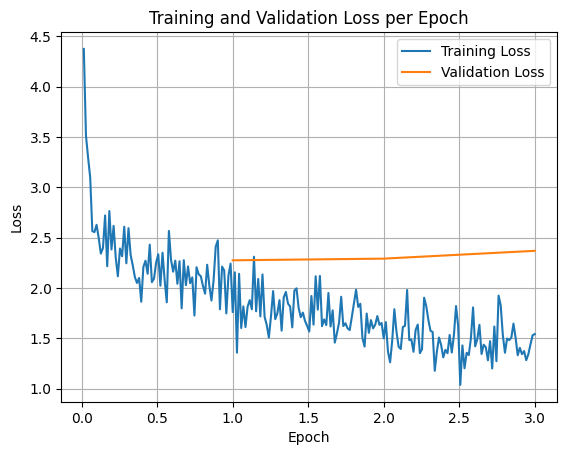

In [22]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Save the model
trainer.save_model()

In [39]:
# Remove all the checkpoint folders (since we've already saved the best model)
!rm -rf ./checkpoint_models/checkpoint-*/*
!rm -rf ./checkpoint_models/checkpoint-*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load the trained model back in and see how it performs

We've now fine-tuned our own Gemma 3 270M to do a specific task, let's load it back in and see how it performs.

In [40]:
CHECKPOINT_DIR_NAME

'./checkpoint_models'

In [41]:
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=CHECKPOINT_DIR_NAME,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
);

In [42]:
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

Device set to use cuda:0


In [43]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 284
})

Let's now perform inference with our fine-tuned model on a random sample from the test dataset (our model has never seen these samples).

In [28]:
# Get a random sample
random_test_idx = get_random_idx(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt, 
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
The image shows a package of "Helpful Harvest" dried vegetables. The ingredients include a variety of vegetables such as zucchini, carrots, mushrooms, onions, capsicum, and celery. The product is made from 100% vegetables and includes wonky and overly abundant produce where possible. The package notes that the ingredients and percentages may differ due to seasonal availability.

The allergens listed are milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, and almonds. The nutrition information indicates that the package contains 4 servings, with each serving size being 10g. The average quantities per serving are as follows:
- Energy: 125 kJ
- Protein: 1.9 g
- Gluten: 0 g (marked as gluten-free)
- Fat, total: 0.3 g
- Saturated fat: 0 g
- Carbohydrate: 3.4 g
- Sugars: 3.4 g
- Fibre: 3.4 g
- Sodium: 2.1 g

The average quantities per 100g are:
- Energy: 1250 kJ
- Protein: 18.7 g
- Fat, total: 2.8 g
- Saturated fat: 0 g
- Carbohydrate: 34.3 g

In [29]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fi, fp
foods: zucchini, carrots, mushrooms, onions, capsicum, celery, milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, almonds
drinks:


## Counting the number of parameters in our model

In [30]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


In [31]:
# Our model is 270M parameters, GPT-OSS-120B is 120B parameters
120_000_000_000 / 270_000_000

444.44444444444446

By fine-tuning Gemma 3 270M we distill the capabilities of a 120B parameter model into a model 444x smaller.

## Uploading our fine-tuned model to the Hugging Face Hub

We can upload our fine-tuned model to the Hugging Face Hub so other people can use it and test it out.

First, let's load it in ourselves and confirm it works how we'd like it to.

In [32]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

MODEL_PATH = "./checkpoint_models/"

# Load the model into a pipeline
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH
)

# Create a pipeline from the loaded model
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

# Test the loaded model on raw text (this won't work as well as formatted text)
test_input_message = "Hello my name is Daniel!"
loaded_model_pipeline(test_input_message)

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
The tokenizer you are loading from './checkpoint_models/' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0


[{'generated_text': "Hello my name is Daniel! I work as a software developer with a passion for creating user-friendly and intuitive web applications. My team, the team at Global Solutions Inc. (which I'm a part of), has a vibrant and collaborative team culture, where we share a common goal of making technology accessible for everyone. We believe that technology should serve our users, and we're committed to providing the best possible solutions."}]

Let's create a helper function to format our input text into message format.

In [33]:
def format_message(input):
    return [{"role": "user", "content": input}]

input_formatted = format_message(input=test_input_message)
input_formatted

[{'role': 'user', 'content': 'Hello my name is Daniel!'}]

Now we can turn it into a prompt with our `tokenizer` and the `apply_chat_template` method.

In [34]:
input_prompt = loaded_model_pipeline.tokenizer.apply_chat_template(conversation=input_formatted,
                                                                   tokenize=False,
                                                                   add_generation_prompt=True)

input_prompt

'<bos><start_of_turn>user\nHello my name is Daniel!<end_of_turn>\n<start_of_turn>model\n'

Beautiful! Time to run our fine-tuned model!

In [35]:
loaded_model_outputs = loaded_model_pipeline(text_inputs=input_prompt,
                                             max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{loaded_model_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Hello my name is Daniel!<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_or_drink: 0
tags: 
foods: 
drinks:


Okay let's make another helper function to predict on any given sample input.

We'll also return the inference time of our model so we can see how long things take.

In [36]:
import time

def pred_on_text(input_text):
    start_time = time.time()
    
    raw_output = loaded_model_pipeline(text_inputs=[{"role": "user",
                                                    "content": input_text}],
                                       max_new_tokens=256,
                                       disable_compile=True)
    end_time = time.time()
    total_time = round(end_time - start_time, 4)

    generated_text = raw_output[0]["generated_text"][1]["content"]

    return generated_text, raw_output, total_time

pred_on_text(input_text="British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes")

('food_or_drink: 1\ntags: fi\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, toast, fried tomatoes\ndrinks: tea',
 [{'generated_text': [{'role': 'user',
     'content': 'British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes'},
    {'role': 'assistant',
     'content': 'food_or_drink: 1\ntags: fi\nfoods: baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, toast, fried tomatoes\ndrinks: tea'}]}],
 0.5977)

Nice! Looks like our model is working well enough (of course we could always improve it over time with more testing and different samples).

Let's upload it to the Hugging Face Hub.

We can do so using the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/en/index).

In [44]:
from huggingface_hub import HfApi, create_repo

api = HfApi()

# Give our model a name (this is in the format [Hugging Face Username]/[Target Model Name]
repo_id = "mrdbourke/FoodExtract-gemma-3-270m-fine-tune-v1"

# Create the repo
create_repo(repo_id, 
            repo_type="model", 
            exist_ok=True)

# Upload the entire model folder containing our model files
api.upload_folder(
    folder_path="./checkpoint_models/",
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/mrdbourke/FoodExtract-gemma-3-270m-fine-tune-v1/commit/825d826ada01faf86dcbd0c5c4d77504f3fa5d04', commit_message='Upload folder using huggingface_hub', commit_description='', oid='825d826ada01faf86dcbd0c5c4d77504f3fa5d04', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mrdbourke/FoodExtract-gemma-3-270m-fine-tune-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='mrdbourke/FoodExtract-gemma-3-270m-fine-tune-v1'), pr_revision=None, pr_num=None)

Woohoo! Our model is officially on the Hugging Face Hub.

Now not only can we redownload it and use it again, others can download it and use it for themselves (of course you can make the model private if you like too).

## Turn our model into a demo

Right now our model seems to be working quite well for our specific use case.

However, it takes some coding to be able to use it.

What if we wanted to allow someone who wasn't familiar with programming to try it out?

To do so, we can turn our model into a [Gradio](https://www.gradio.app) demo and upload it to [Hugging Face Spaces](https://huggingface.co/spaces) (a place to share all kinds of small applications).

Gradio allows us to turn our model into an easy to use and sharable demo anyone can try.

Gradio demos work on the premise of: input (text) -> function (our model) -> output (text) 

We've already go a function ready with `pred_on_text` so we can wrap this with some Gradio code.

To create a sharable demo, we'll need the following files:

* `app.py` - Entry point for our app, all of our application code will go in here.
* `README.md` - Tells people what our app does.
    * **Note:** Hugging Face Spaces use a special "front matter" (text at the start of a `README.md` file) to add various attributes to a Hugging Face Space, we'll see this below.
* `requirements.txt` - Tells Hugging Face Spaces what our app requires.
    * `torch`, `transformers`, `gradio`, `accelerate`
 
Let's make a folder to store our demo application.


In [45]:
!mkdir demos/
!mkdir demos/FoodExtract

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Creating the `app.py` file

When running our app on Hugging Face Spaces, we have the option to run our model on a GPU thanks to Hugging Face's [ZeroGPU](https://huggingface.co/docs/hub/en/spaces-zerogpu) feature. 

This is optional, however, it's highly recommend you run a model such as Gemma 3 270M on the GPU as we'll see significant speedups.

You can run a function on a GPU by importing `spaces` and then using the `@spaces.GPU` decorator on your target function.

```python
import spaces

@spaces.GPU
def function_to_run_on_the_gpu():
    pass
```

To ensure your model runs on the GPU, be sure to select a ZeroGPU instance in your Hugging Face Space settings.

In [46]:
%%writefile demos/FoodExtract/app.py

# Load dependencies
import time
import transformers
import torch
import spaces # Optional: run our model on the GPU (this will be much faster inference)

import gradio as gr

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline

@spaces.GPU # Optional: run our model on the GPU (this will be much faster inference)
def pred_on_text(input_text):
    start_time = time.time()
    
    raw_output = loaded_model_pipeline(text_inputs=[{"role": "user",
                                                    "content": input_text}],
                                       max_new_tokens=256,
                                       disable_compile=True)
    end_time = time.time()
    total_time = round(end_time - start_time, 4)

    generated_text = raw_output[0]["generated_text"][1]["content"]

    return generated_text, raw_output, total_time

# Load the model (from our Hugging Face Repo)
# Note: You may have to replace my username `mrdbourke` for your own
MODEL_PATH = "mrdbourke/FoodExtract-gemma-3-270m-fine-tune-v1"

# Load the model into a pipeline
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH
)

# Create model pipeline
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

# Create the demo
description = """Extract food and drink items from text with a fine-tuned SLM (Small Language Model) or more specifically a fine-tuned [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m-it).

Our model has been fine-tuned on the [FoodExtract-1k dataset](https://huggingface.co/datasets/mrdbourke/FoodExtract-1k). 

* Input (str): Raw text strings or image captions (e.g. "A photo of a dog sitting on a beach" or "A breakfast plate with bacon, eggs and toast")
* Output (str): Generated text with food/not_food classification as well as noun extracted food and drink items and various food tags.

For example:

* Input: "For breakfast I had eggs, bacon and toast and a glass of orange juice"
* Output: 

```
food_or_drink: 1
tags: fi, di
foods: eggs, bacon, toast
drinks: orange juice
```
"""

demo = gr.Interface(fn=pred_on_text,
                    inputs=gr.TextArea(lines=4, label="Input Text"),
                    outputs=[gr.TextArea(lines=4, label="Generated Text"),
                             gr.TextArea(lines=7, label="Raw Output"),
                             gr.Number(label="Generation Time (s)")],
                    title="🍳 Structured FoodExtract with a Fine-Tuned Gemma 3 270M",
                    description=description,
                    examples=[["Hello world! This is my first fine-tuned LLM!"],
                              ["A plate of food with grilled barramundi, salad with avocado, olives, tomatoes and Italian dressing"],
                              ["British Breakfast with baked beans, fried eggs, black pudding, sausages, bacon, mushrooms, a cup of tea and toast and fried tomatoes"],
                              ["Steak tacos"],
                              ["A photo of a dog sitting on a beach"]]
)

if __name__ == "__main__":
    demo.launch(share=False)


Writing demos/FoodExtract/app.py


### Create the `README.md` file

The `README.md` file will tell people what our app does.

We could add more information here if we wanted to but for now we'll keep it simple.

Notice the special text at the top of the file below (the text between the `---`), these are some settings for the Space, you can see the [settings for these in the docs](https://huggingface.co/docs/hub/en/spaces-config-reference).

In [47]:
%%writefile demos/FoodExtract/README.md
---
title: FoodExtract Fine-tuned LLM Structued Data Extractor
emoji: 📝➡️🍟
colorFrom: green
colorTo: blue
sdk: gradio
app_file: app.py
pinned: false
license: apache-2.0
---

"""
Fine-tuned Gemma 3 270M to extract food and drink items from raw text.

Input can be any form of real text and output will be a formatted string such as the following:

```
food_or_drink: 1
tags: fi, re
foods: tacos, milk, red apple, pineapple, cherries, fried chicken, steak, mayonnaise
drinks: iced latte, matcha latte
```

The tags map to the following items:

```
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}
```
"""

Writing demos/FoodExtract/README.md


### Create the `requirements.txt` file

This will tell the Hugging Face Space what libraries we'd like it to run inside.

In [48]:
%%writefile demos/FoodExtract/requirements.txt
transformers
gradio
torch
accelerate

Writing demos/FoodExtract/requirements.txt


### Upload our demo to the Hugging Face Hub

We can upload our demo to the Hugging Face Hub in a similar way to uploading our model.

We could also upload it file by file via the Hugging Face Spaces interface.

But let's stick to the code-first approach.

In [49]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/FoodExtract/"
HF_TARGET_SPACE_NAME = "FoodExtract-v1"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub 
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists 
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading FoodExtract demo app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: FoodExtract-v1
[INFO] Full Hugging Face Hub repo name: mrdbourke/FoodExtract-v1
[INFO] Uploading demos/FoodExtract/ to repo: mrdbourke/FoodExtract-v1
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/mrdbourke/FoodExtract-v1/tree/main/.


Nice!

It looks like our demo upload worked!

We can try it out via the URL (in my case, it's: [https://huggingface.co/spaces/mrdbourke/FoodExtract-v1](https://huggingface.co/spaces/mrdbourke/FoodExtract-v1)). And we can even embed it right in our notebook.

In [50]:
from IPython.display import HTML

html_code = """<iframe
	src="https://mrdbourke-foodextract-v1.hf.space"
	frameborder="0"
	width="850"
	height="1000"
></iframe>"""

display(HTML(html_code))

How cool!

We've now got a sharable demo of a fine-tuned LLM which anyone can try out for themselves.

## Bonus: Speeding up our model with batched inference

Right now our model only inferences on one sample at a time but as is the case with many machine learning models, we could perform inference on multiple samples (also referred to as a batch) to significantly improve throughout.

In batched inference mode, your model performs predictions on X number of samples at once, this can dramatically improve sample throughput.

The number of samples you can predict on at once will depend on a few factors: 

* The size of your model (e.g. if your model is quite large, it may only be able to predict on 1 sample at time)
* The size of your compute VRAM (e.g. if your compute VRAM is already saturated, add multiple samples at a time may result in errors)
* The size of your samples (if one of your samples is 100x the size of others, this may cause errors with batched inference)

To find an optimal batch size for our setup, we can run an experiment:

* Loop through different batch sizes and measure the throughput for each batch size.
    * Why do we do this?
        * It's hard to tell the ideal batch size ahead of time.
        * So we experiment from say 1, 2, 4, 8, 16, 32, 64 batch sizes and see which performs best.
        * Just because we may get a speed up from using batch size 8, doesn't mean 64 will be better. 

In [51]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of samples in the dataset: {len(dataset['train'])}")

def sample_to_conversation(sample):
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

# Map our sample_to_conversation function to dataset 
dataset = dataset.map(sample_to_conversation,
                      batched=False)

# Create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2,
                                            shuffle=False,
                                            seed=42)

# Number #1 rule in machine learning
# Always train on the train set and test on the test set
# This gives us an indication of how our model will perform in the real world
dataset

[INFO] Number of samples in the dataset: 1420


DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

In [52]:
# Step 1: Need to turn our samples into batches (e.g. lists of samples)
print(f"[INFO] Formatting test samples into list prompts...")
test_input_prompts = [
    loaded_model_pipeline.tokenizer.apply_chat_template(
        item["messages"][:1],
        tokenize=False,
        add_generation_prompt=True
    )
    for item in dataset["test"]
]
print(f"[INFO] Number of test sample prompts: {len(test_input_prompts)}")
test_input_prompts[0]

[INFO] Formatting test samples into list prompts...
[INFO] Number of test sample prompts: 284


'<bos><start_of_turn>user\nLiving Planet Goat Milk Whole Milk, 1 Litre, GMO Free, Australian Dairy, 8.75g Protein Per Serve, Good Source of Calcium.<end_of_turn>\n<start_of_turn>model\n'

In [53]:
# Step 2: Need to perform batched inference and time each step
import time
from tqdm.auto import tqdm

all_outputs = []

# Let's write a list of batch sizes to test
chunk_sizes_to_test = [1, 4, 8, 16, 32, 64, 128]
timing_dict = {}

# Loop through each batch size and time the inference
for CHUNK_SIZE in chunk_sizes_to_test:
    print(f"[INFO] Making predictions with batch size: {CHUNK_SIZE}")
    start_time = time.time()

    for chunk_number in tqdm(range(round(len(test_input_prompts) / CHUNK_SIZE))):
        batched_inputs = test_input_prompts[(CHUNK_SIZE * chunk_number): CHUNK_SIZE * (chunk_number + 1)]
        batched_outputs = loaded_model_pipeline(text_inputs=batched_inputs,
                                                batch_size=CHUNK_SIZE,
                                                max_new_tokens=256,
                                                disable_compile=True)
        
        all_outputs += batched_outputs
    
    end_time = time.time()
    total_time = end_time - start_time
    timing_dict[CHUNK_SIZE] = total_time
    print()
    print(f"[INFO] Total time for batch size {CHUNK_SIZE}: {total_time:.2f}s")
    print("="*80 + "\n\n")

[INFO] Making predictions with batch size: 1


  0%|          | 0/284 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



[INFO] Total time for batch size 1: 144.40s


[INFO] Making predictions with batch size: 4


  0%|          | 0/71 [00:00<?, ?it/s]


[INFO] Total time for batch size 4: 52.49s


[INFO] Making predictions with batch size: 8


  0%|          | 0/36 [00:00<?, ?it/s]


[INFO] Total time for batch size 8: 36.89s


[INFO] Making predictions with batch size: 16


  0%|          | 0/18 [00:00<?, ?it/s]


[INFO] Total time for batch size 16: 29.80s


[INFO] Making predictions with batch size: 32


  0%|          | 0/9 [00:00<?, ?it/s]


[INFO] Total time for batch size 32: 33.65s


[INFO] Making predictions with batch size: 64


  0%|          | 0/4 [00:00<?, ?it/s]


[INFO] Total time for batch size 64: 31.30s


[INFO] Making predictions with batch size: 128


  0%|          | 0/2 [00:00<?, ?it/s]


[INFO] Total time for batch size 128: 48.09s




Batched inference complete! Let's make a plot comparing different batch sizes.

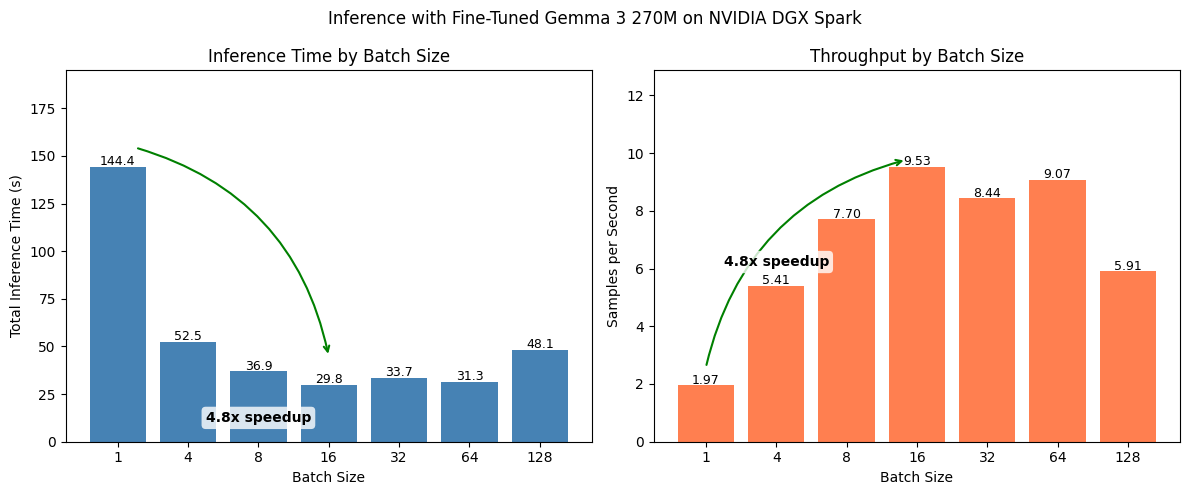

In [54]:
import matplotlib.pyplot as plt

# Data
data = timing_dict

total_samples = len(dataset["test"])

batch_sizes = list(data.keys())
inference_times = list(data.values())
samples_per_second = [total_samples / time for bs, time in data.items()]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Left plot: Total Inference Time ---
ax1.bar([str(bs) for bs in batch_sizes], inference_times, color='steelblue')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Total Inference Time (s)')
ax1.set_title('Inference Time by Batch Size')

for i, v in enumerate(inference_times):
    ax1.text(i, v + 1, f'{v:.1f}', ha='center', fontsize=9)

# --- ARROW LOGIC (Left) ---
# 1. Identify Start (Slowest) and End (Fastest)
start_val = max(inference_times)
end_val = min(inference_times)
start_idx = inference_times.index(start_val)
end_idx = inference_times.index(end_val)

speedup = start_val / end_val

# 2. Draw Arrow (No Text)
# connectionstyle "rad=-0.3" arcs the arrow upwards
ax1.annotate("",
             xy=(end_idx, end_val+(0.5*end_val)),
             xytext=(start_idx+0.25, start_val+10),
             arrowprops=dict(arrowstyle="->", color='green', lw=1.5, connectionstyle="arc3,rad=-0.3"))

# 3. Place Text at Midpoint
mid_x = (start_idx + end_idx) / 2
# Place text slightly above the highest point of the two bars
text_y = max(start_val, end_val) + (max(inference_times) * 0.1)

ax1.text(mid_x+0.5, text_y-150, f"{speedup:.1f}x speedup",
         ha='center', va='bottom', fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8))

ax1.set_ylim(0, max(inference_times) * 1.35) # Increase headroom for text


# --- Right plot: Samples per Second ---
ax2.bar([str(bs) for bs in batch_sizes], samples_per_second, color='coral')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Samples per Second')
ax2.set_title('Throughput by Batch Size')

for i, v in enumerate(samples_per_second):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=9)

# --- ARROW LOGIC (Right) ---
# 1. Identify Start (Slowest) and End (Fastest)
start_val_t = min(samples_per_second)
end_val_t = max(samples_per_second)
start_idx_t = samples_per_second.index(start_val_t)
end_idx_t = samples_per_second.index(end_val_t)

speedup_t = end_val_t / start_val_t

# 2. Draw Arrow (No Text)
ax2.annotate("",
             xy=(end_idx_t-(0.05*end_idx_t), end_val_t+(0.025*end_val_t)),
             xytext=(start_idx_t, start_val_t+0.6),
             arrowprops=dict(arrowstyle="->", color='green', lw=1.5, connectionstyle="arc3,rad=-0.3"))

# 3. Place Text at Midpoint
mid_x_t = (start_idx_t + end_idx_t) / 2
text_y_t = max(start_val_t, end_val_t) + (max(samples_per_second) * 0.1)

ax2.text(mid_x_t-0.5, text_y_t-4.5, f"{speedup_t:.1f}x speedup",
         ha='center', va='bottom', fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8))

ax2.set_ylim(0, max(samples_per_second) * 1.35) # Increase headroom

plt.suptitle("Inference with Fine-Tuned Gemma 3 270M on NVIDIA DGX Spark")
plt.tight_layout()
plt.savefig('inference_benchmark.png', dpi=150)
plt.show()

We get a 4-6x speedup when using batches!

At 10 samples per second, that means we can inference on ~800k samples in a day.

In [62]:
samples_per_second = round(len(dataset["test"]) / min(timing_dict.values()), 2)
seconds_in_a_day = 86_400
samples_per_day = seconds_in_a_day * samples_per_second

print(f"[INFO] Number of samples per second: {samples_per_second} | Number of samples per day: {samples_per_day}")

[INFO] Number of samples per second: 9.53 | Number of samples per day: 823392.0


## Bonus: Performing evaluations on our model

We can evaluate our model directly against the original labels from `gpt-oss-120b` and see how it stacks up.

For example, we could compare the following:

* F1 Score
* Precision
* Recall
* Pure accuracy

Have these metrics as well as samples which are different to the ground truth would allow us to further explore where our model needs improvements.

## Next steps

There are several avenues we could approach next.

1. Improve the data sampling - if our model makes mistakes, could we improve the input data? For example, more samples on certain tasks where the model is weaker.

2. Quantisation - right now our model is ~500MB, could we make this smaller with the help of INT8 quantisation? (this could also help speed up inference time)

3. Output compression - our output is compressed to a simple YAML-like format, but is there a better compression option to generate even less tokens?

4. Test the model on a large unseen sample - practice using the model on a large corpus of image captions (e.g. 10,000+) and randomly inspect them to find failure cases to boost the model performance
